## Student Name: Tadhg Philibin e Silva
## Student ID: 22275363

Open a new Jupyter notebook and name it etivity2.ipynb. In your notebook, load bank.csv into a Pandas dataframe. Follow the examples and process in Lab 2 - Data Preparation.ipynb to prepare bank.csv for machine learning.

Ensure that you have:

- encoded all categorical attributes as numerical,
- filled in all missing values
- applied a scaler to rescale features
- treated outliers appropriately
- created at least one new feature from the existing ones

Shortly describe and Justify the data preparation choices you have taken in markdown cells. Aim at not having markdown cells longer than 2-3 lines of text.

In the end, save the prepared dataset as a CSV file on your hard disk.

In [951]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [952]:
df = pd.read_csv("./bank.csv")
df_copy = df.copy(deep=True)
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

In [953]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1988 non-null   float64
 1   job         1990 non-null   object 
 2   marital     2000 non-null   object 
 3   education   1896 non-null   object 
 4   default     2000 non-null   object 
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   object 
 7   loan        2000 non-null   object 
 8   contact     1809 non-null   object 
 9   day         2000 non-null   int64  
 10  month       2000 non-null   object 
 11  duration    2000 non-null   int64  
 12  campaign    2000 non-null   int64  
 13  pdays       2000 non-null   int64  
 14  previous    2000 non-null   int64  
 15  poutcome    1546 non-null   object 
 16  subscribed  2000 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 265.8+ KB


In [954]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

# Fill in all missing values

In [955]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

Total  Percent
poutcome     454   0.2270
contact      191   0.0955
education    104   0.0520
age           12   0.0060
job           10   0.0050
default        0   0.0000

Useful information is not readily available regarding the missing values for **contact**. The dataset description for this feature simply says:

    contact communication type (categorical: 'cellular','telephone')
    
Since we cannot readily infer whether a NaN value should be cellular or telephone, we will just label them as 'missing'

In [956]:
df['contact'] = df['contact'].fillna(value='missing')

Education may be considered an ordinal variable given that is progressive. We can fill in NaNs with 'missing' and convert it to an ordinal numeric value.

In [957]:
df['education'].unique()

array(['tertiary', 'secondary', nan, 'primary'], dtype=object)

In [958]:
cat = pd.Categorical(df.education, 
                     categories=['missing', 'primary', 
                                 'secondary', 'tertiary'], 
                     ordered=True)

cat.fillna('missing')

labels, _ = pd.factorize(cat, sort=True)
df.education = labels

df['education']

0       2
1       1
2       1
3       1
4       1
       ..
1995   -1
1996    1
1997    0
1998    0
1999    1
Name: education, Length: 2000, dtype: int64

For dealing with month, we could convert it to a categorical variable, but we are losing the cyclical properties of this feature. By converting it to its numerical equivalent, and then recasting it as two features - a function of sin and a function of cosine. We gain a feature but we preserve the fact that December is close to January.

In [959]:
df['month'].unique()

array(['apr', 'dec', 'feb', 'jan', 'mar', 'may', 'nov', 'oct', 'aug',
       'jul', 'jun', 'sep'], dtype=object)

In [960]:
scale_mapper = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12
}

df['month'] = df['month'].replace(scale_mapper)

df['month'].unique()

array([ 4, 12,  2,  1,  3,  5, 11, 10,  8,  7,  6,  9])

In [961]:
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

In [962]:
df['month_sin'].unique()

array([ 1.00000000e+00, -5.00000000e-01,  5.00000000e-01,  0.00000000e+00,
        8.66025404e-01,  8.66025404e-01, -8.66025404e-01, -1.00000000e+00,
       -5.00000000e-01,  1.22464680e-16,  5.00000000e-01, -8.66025404e-01])

We will do something similar for day. We will make the assumption that all months have 31 days. I guess this could mean that the weighting of day-of-the-month is very slightly off for some days/months but it's a small price to pay I believe.

In [963]:
df['day_sin'] = np.sin((df.day-1)*(2.*np.pi/31))
df['day_cos'] = np.cos((df.day-1)*(2.*np.pi/31))

In [964]:
df.drop('month', axis=1, inplace=True)
df.drop('day', axis=1, inplace=True)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'subscribed', 'month_sin', 'month_cos', 'day_sin',
       'day_cos'],
      dtype='object')

In [965]:
df.isna().sum()

age            12
job            10
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
month_sin       0
month_cos       0
day_sin         0
day_cos         0
dtype: int64

Next, lets explore age and see if we can interpolate some values based on other attributes

In [966]:
df[df['age'].isna()].sort_values(by=['job'])

age            job  marital  education default  balance housing loan  \
601   NaN         admin.   single          1      no      111     yes   no   
472   NaN    blue-collar  married          0      no      474     yes  yes   
595   NaN     management  married          2      no     1857      no   no   
605   NaN     management  married          2      no     1330     yes   no   
744   NaN     management  married          2      no      -61      no   no   
1171  NaN        retired  married          2      no     2812      no   no   
456   NaN  self-employed  married          2      no      917      no   no   
597   NaN  self-employed  married          1     yes      254     yes  yes   
1408  NaN  self-employed   single          2      no      251      no   no   
526   NaN       services  married          1      no     2478     yes   no   
1232  NaN        student   single          1      no      431      no   no   
795   NaN     technician   single          2      no      992     yes   no   

        contact  duration  campaign  pdays  previous poutcome subscribed  \
601    cellular        55         1    195         3  failure         no   
472   telephone       152         3    221         1  failure         no   
595    cellular       386         1    168         4  failure         no   
605    cellular        41         2    261         1  failure         no   
744    cellular        90         5    172         1  failure         no   
1171   cellular       392         4    181         3  success        yes   
456    cellular       518         3    212         5  failure         no   
597    cellular       194         1    188         1  failure         no   
1408   cellular       537         1     -1         0      NaN        yes   
526    cellular       347         1    230         1  failure         no   
1232   cellular       418        11    185         5  success        yes   
795    cellular       301         1     88         2  success         no   

         month_sin  month_cos   day_sin   day_cos  
601   0.000000e+00   1.000000 -0.571268  0.820763  
472   5.000000e-01   0.866025  0.998717 -0.050649  
595   0.000000e+00   1.000000 -0.571268  0.820763  
605   0.000000e+00   1.000000 -0.571268  0.820763  
744   0.000000e+00   1.000000 -0.394356  0.918958  
1171 -5.000000e-01  -0.866025  0.394356  0.918958  
456   5.000000e-01   0.866025  0.848644  0.528964  
597   0.000000e+00   1.000000 -0.571268  0.820763  
1408  1.224647e-16  -1.000000  0.790776 -0.612106  
526   0.000000e+00   1.000000 -0.724793  0.688967  
1232 -5.000000e-01  -0.866025 -0.485302 -0.874347  
795   8.660254e-01  -0.500000  0.571268  0.820763

There appear to be some clusters we ce can exploit here for our handling of missing values. Presumably, for the missing values at index 1171, the age is better imputed by the average of the other retired people, than by an average that would be brought down by students. So we shall carry out this clustering exercise and see if the averages in the  clusters deviate from the averages of the group at large.

In [967]:
married_educated_mgmt = df[(df['job'] == 'management') & (df['education'] == 2) & (df['marital'] == 'married')]
married_educated_mgmt

age         job  marital  education default  balance housing loan  \
24    57.0  management  married          2      no     1631     yes   no   
25    37.0  management  married          2      no      489     yes   no   
52    42.0  management  married          2      no       72     yes   no   
68    35.0  management  married          2      no     1473     yes   no   
81    42.0  management  married          2      no      144      no   no   
...    ...         ...      ...        ...     ...      ...     ...  ...   
1949  34.0  management  married          2      no     3301     yes   no   
1957  59.0  management  married          2      no     5397      no   no   
1960  49.0  management  married          2      no     1167     yes  yes   
1982  28.0  management  married          2      no       12     yes   no   
1984  58.0  management  married          2      no        0      no   no   

       contact  duration  campaign  pdays  previous poutcome subscribed  \
24    cellular       254         2    261         3  failure         no   
25    cellular       246         2    133         6  failure         no   
52    cellular       124         2    348         3  failure         no   
68    cellular        17         6    322         4    other         no   
81    cellular       143         1    283         3  failure         no   
...        ...       ...       ...    ...       ...      ...        ...   
1949  cellular       164         5     92         6  success        yes   
1957  cellular       244         1     92         3  success        yes   
1960  cellular       249         1     91        14  success        yes   
1982  cellular       202         1     -1         0      NaN        yes   
1984  cellular       358         2     -1         0      NaN        yes   

      month_sin     month_cos   day_sin   day_cos  
24     1.000000  6.123234e-17  0.201299  0.979530  
25     1.000000  6.123234e-17  0.394356  0.918958  
52     1.000000  6.123234e-17 -0.651372 -0.758758  
68     1.000000  6.123234e-17 -0.651372 -0.758758  
81    -0.500000  8.660254e-01  0.937752  0.347305  
...         ...           ...       ...       ...  
1949  -0.866025 -5.000000e-01 -0.101168 -0.994869  
1957  -0.866025 -5.000000e-01 -0.968077 -0.250653  
1960  -0.866025 -5.000000e-01 -0.998717 -0.050649  
1982  -0.866025 -5.000000e-01  0.998717 -0.050649  
1984  -0.866025 -5.000000e-01  0.485302 -0.874347  

[195 rows x 19 columns]

In [968]:
married_educated_mgmt['age'].sum() / len(married_educated_mgmt)

41.717948717948715

As can be seen here, the average married, college educated manager is aged 41, well beyond that of the average student. So, their missing values are imputed by the average of their peers rather than the group as a whole.

In [969]:
df.at[595,'age']=41
df.at[605,'age']=41
df.at[744,'age']=41

In [970]:
df[df['age'].isna()].sort_values(by=['job'])

age            job  marital  education default  balance housing loan  \
601   NaN         admin.   single          1      no      111     yes   no   
472   NaN    blue-collar  married          0      no      474     yes  yes   
1171  NaN        retired  married          2      no     2812      no   no   
456   NaN  self-employed  married          2      no      917      no   no   
597   NaN  self-employed  married          1     yes      254     yes  yes   
1408  NaN  self-employed   single          2      no      251      no   no   
526   NaN       services  married          1      no     2478     yes   no   
1232  NaN        student   single          1      no      431      no   no   
795   NaN     technician   single          2      no      992     yes   no   

        contact  duration  campaign  pdays  previous poutcome subscribed  \
601    cellular        55         1    195         3  failure         no   
472   telephone       152         3    221         1  failure         no   
1171   cellular       392         4    181         3  success        yes   
456    cellular       518         3    212         5  failure         no   
597    cellular       194         1    188         1  failure         no   
1408   cellular       537         1     -1         0      NaN        yes   
526    cellular       347         1    230         1  failure         no   
1232   cellular       418        11    185         5  success        yes   
795    cellular       301         1     88         2  success         no   

         month_sin  month_cos   day_sin   day_cos  
601   0.000000e+00   1.000000 -0.571268  0.820763  
472   5.000000e-01   0.866025  0.998717 -0.050649  
1171 -5.000000e-01  -0.866025  0.394356  0.918958  
456   5.000000e-01   0.866025  0.848644  0.528964  
597   0.000000e+00   1.000000 -0.571268  0.820763  
1408  1.224647e-16  -1.000000  0.790776 -0.612106  
526   0.000000e+00   1.000000 -0.724793  0.688967  
1232 -5.000000e-01  -0.866025 -0.485302 -0.874347  
795   8.660254e-01  -0.500000  0.571268  0.820763

In [971]:
married_educated_retired = df[(df['job'] == 'retired') & (df['education'] == 2) & (df['marital'] == 'married')]
married_educated_retired['age'].sum() / len(married_educated_retired)

63.333333333333336

In [972]:
df.at[1171,'age']=63

In [973]:
df[df['age'].isna()].sort_values(by=['job'])

age            job  marital  education default  balance housing loan  \
601   NaN         admin.   single          1      no      111     yes   no   
472   NaN    blue-collar  married          0      no      474     yes  yes   
456   NaN  self-employed  married          2      no      917      no   no   
597   NaN  self-employed  married          1     yes      254     yes  yes   
1408  NaN  self-employed   single          2      no      251      no   no   
526   NaN       services  married          1      no     2478     yes   no   
1232  NaN        student   single          1      no      431      no   no   
795   NaN     technician   single          2      no      992     yes   no   

        contact  duration  campaign  pdays  previous poutcome subscribed  \
601    cellular        55         1    195         3  failure         no   
472   telephone       152         3    221         1  failure         no   
456    cellular       518         3    212         5  failure         no   
597    cellular       194         1    188         1  failure         no   
1408   cellular       537         1     -1         0      NaN        yes   
526    cellular       347         1    230         1  failure         no   
1232   cellular       418        11    185         5  success        yes   
795    cellular       301         1     88         2  success         no   

         month_sin  month_cos   day_sin   day_cos  
601   0.000000e+00   1.000000 -0.571268  0.820763  
472   5.000000e-01   0.866025  0.998717 -0.050649  
456   5.000000e-01   0.866025  0.848644  0.528964  
597   0.000000e+00   1.000000 -0.571268  0.820763  
1408  1.224647e-16  -1.000000  0.790776 -0.612106  
526   0.000000e+00   1.000000 -0.724793  0.688967  
1232 -5.000000e-01  -0.866025 -0.485302 -0.874347  
795   8.660254e-01  -0.500000  0.571268  0.820763

We perform the same for self-employed...

In [974]:
educated_selfemployed_nohousing = df[
    (df['job'] == 'self-employed') 
    & (df['education'] == 2) 
    & (df['housing'] == 'no')]

educated_selfemployed_nohousing['age'].sum() / len(educated_selfemployed_nohousing)

34.142857142857146

In [975]:
df.at[456,'age']=34
df.at[1408,'age']=34

In [976]:
secondaryedu_selfemployed_withhousing = df[
    (df['job'] == 'self-employed') 
    & (df['education'] == 1) 
    & (df['housing'] == 'yes')]

secondaryedu_selfemployed_withhousing['age'].sum() / len(secondaryedu_selfemployed_withhousing)

37.7

In [977]:
df.at[597,'age']=38

In [978]:
df[df['age'].isna()].sort_values(by=['job'])

age          job  marital  education default  balance housing loan  \
601   NaN       admin.   single          1      no      111     yes   no   
472   NaN  blue-collar  married          0      no      474     yes  yes   
526   NaN     services  married          1      no     2478     yes   no   
1232  NaN      student   single          1      no      431      no   no   
795   NaN   technician   single          2      no      992     yes   no   

        contact  duration  campaign  pdays  previous poutcome subscribed  \
601    cellular        55         1    195         3  failure         no   
472   telephone       152         3    221         1  failure         no   
526    cellular       347         1    230         1  failure         no   
1232   cellular       418        11    185         5  success        yes   
795    cellular       301         1     88         2  success         no   

      month_sin  month_cos   day_sin   day_cos  
601    0.000000   1.000000 -0.571268  0.820763  
472    0.500000   0.866025  0.998717 -0.050649  
526    0.000000   1.000000 -0.724793  0.688967  
1232  -0.500000  -0.866025 -0.485302 -0.874347  
795    0.866025  -0.500000  0.571268  0.820763

We perform the same for the remaining...

In [979]:
admin_secondaryeducation = df[
    (df['job'] == 'admin.') 
    & (df['education'] == 1)]
df.at[601, 'age'] = int(admin_secondaryeducation['age'].sum() / len(admin_secondaryeducation))

In [980]:
bluecollar_married_primary = df[
    (df['job'] == 'blue-collar') 
    & (df['education'] == 0)
    & (df['marital'] == 'married')]
df.at[472, 'age'] = int(bluecollar_married_primary['age'].sum() / len(bluecollar_married_primary))

In [981]:
services_married_secondary = df[
    (df['job'] == 'services') 
    & (df['education'] == 1)
    & (df['marital'] == 'married')]

df.at[526, 'age'] = int(services_married_secondary['age'].sum() / len(services_married_secondary))

In [982]:
college_student = df[
    (df['job'] == 'student') 
    & (df['education'] == 1)]

df.at[1232,'age']= college_student['age'].sum() / len(college_student)

In [983]:
technician_single_college = df[
    (df['job'] == 'technician') 
    & (df['education'] == 2)
    & (df['marital'] == 'single')]

df.at[795, 'age'] = int(technician_single_college['age'].sum() / len(technician_single_college))

In [984]:
df.isna().sum()

age             0
job            10
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
month_sin       0
month_cos       0
day_sin         0
day_cos         0
dtype: int64

Our age column no longer has any missing values!

In [985]:
df[df['job'].isna()]

age  job  marital  education default  balance housing loan    contact  \
255   42.0  NaN   single          0      no     2398     yes   no   cellular   
257   46.0  NaN  married         -1      no      677      no   no   cellular   
831   41.0  NaN   single          0      no     2398     yes   no    missing   
1223  55.0  NaN  married          1      no     2206      no   no   cellular   
1281  50.0  NaN  married         -1      no      558      no   no   cellular   
1669  54.0  NaN  married          1      no     2206      no   no   cellular   
1711  77.0  NaN  married         -1      no      397      no   no  telephone   
1801  28.0  NaN   single         -1      no      326      no   no   cellular   
1868  48.0  NaN   single         -1      no     1819      no   no   cellular   
1975  45.0  NaN  married          2      no      406      no   no   cellular   

      duration  campaign  pdays  previous poutcome subscribed     month_sin  \
255        144         2    271         2  failure         no  5.000000e-01   
257        425         1     82         1  failure         no  5.000000e-01   
831        287         2     -1         0      NaN         no  8.660254e-01   
1223       265         1     91         5  success        yes -5.000000e-01   
1281       464         1    683         6  failure        yes  1.224647e-16   
1669       260         1     91         4  success        yes  8.660254e-01   
1711       300         3     -1         0      NaN        yes  8.660254e-01   
1801       450         1    231         1  success        yes -1.000000e+00   
1868      1440         1    458         1  failure        yes -8.660254e-01   
1975       314         1     -1         0      NaN        yes -8.660254e-01   

         month_cos   day_sin   day_cos  
255   8.660254e-01  0.394356  0.918958  
257   8.660254e-01  0.394356  0.918958  
831  -5.000000e-01  0.988468  0.151428  
1223 -8.660254e-01  0.790776 -0.612106  
1281 -1.000000e+00  0.998717 -0.050649  
1669 -5.000000e-01  0.651372 -0.758758  
1711 -5.000000e-01  0.937752  0.347305  
1801 -1.836970e-16  0.897805 -0.440394  
1868 -5.000000e-01  0.201299  0.979530  
1975 -5.000000e-01  0.937752  0.347305

Trying to impute the job category is too difficult as far as I can tell. The choice of employment is not dependent on the other features as much as they are dependent on the choice of employment. Perhaps education levels and age could serve us here to some degree, but I think a better option is to simply classify them as unknown values rather than risk corrupting the other job categories.

In [986]:
df['job'] = df['job'].fillna(value='unknown')

In [987]:
df.isna().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
month_sin       0
month_cos       0
day_sin         0
day_cos         0
dtype: int64

In [988]:
df['poutcome'].unique()

array(['failure', 'other', 'success', nan], dtype=object)

In [989]:
df[(df['poutcome'].isna()) & (df['previous'] > 0)]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, duration, campaign, pdays, previous, poutcome, subscribed, month_sin, month_cos, day_sin, day_cos]
Index: []

Every single one of the samples where **poutcome** is NaN, have a **previous** number of calls equal to 0. We can infer that this means that previous outcome is null simply because there was no previous contact, and will interpolate it as such.

In [990]:
df['poutcome'] = df['poutcome'].fillna('no_previous_contact')

In [991]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
month_sin     0
month_cos     0
day_sin       0
day_cos       0
dtype: int64

We have now resolved all missing variables!

# Encoded all categorical attributes as numerical

In [992]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         2000 non-null   float64
 1   job         2000 non-null   object 
 2   marital     2000 non-null   object 
 3   education   2000 non-null   int64  
 4   default     2000 non-null   object 
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   object 
 7   loan        2000 non-null   object 
 8   contact     2000 non-null   object 
 9   duration    2000 non-null   int64  
 10  campaign    2000 non-null   int64  
 11  pdays       2000 non-null   int64  
 12  previous    2000 non-null   int64  
 13  poutcome    2000 non-null   object 
 14  subscribed  2000 non-null   object 
 15  month_sin   2000 non-null   float64
 16  month_cos   2000 non-null   float64
 17  day_sin     2000 non-null   float64
 18  day_cos     2000 non-null   float64
dtypes: float64(5), int64(6), ob

For the rest of the categorical variables, I will just create dummies and have them treated as booleans.

In [993]:
df = pd.get_dummies(df,
                    columns=['default', 'job', 'marital', 'housing', 'loan',
                             'contact', 'poutcome','subscribed'], 
                    drop_first=True)

I hesitated to include 'job' in the list here due to the size of this categorical variable. If it only included general classes of employment such as unemployed, self-employed, retired it would be an easier choice. However it is more granular than that and includes professions like 'housemaid'. These extra values mean that creating dummies for this feature results in quite a few more new features than is ideal.

In [994]:
df.columns

Index(['age', 'education', 'balance', 'duration', 'campaign', 'pdays',
       'previous', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'default_yes', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'housing_yes', 'loan_yes',
       'contact_missing', 'contact_telephone', 'poutcome_no_previous_contact',
       'poutcome_other', 'poutcome_success', 'subscribed_yes'],
      dtype='object')

In [995]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           2000 non-null   float64
 1   education                     2000 non-null   int64  
 2   balance                       2000 non-null   int64  
 3   duration                      2000 non-null   int64  
 4   campaign                      2000 non-null   int64  
 5   pdays                         2000 non-null   int64  
 6   previous                      2000 non-null   int64  
 7   month_sin                     2000 non-null   float64
 8   month_cos                     2000 non-null   float64
 9   day_sin                       2000 non-null   float64
 10  day_cos                       2000 non-null   float64
 11  default_yes                   2000 non-null   uint8  
 12  job_blue-collar               2000 non-null   uint8  
 13  job

# Apply a scaler to rescale features

We use the RobustScaler scaler so that our data is not too skewed by the outliers, e.g. those  seen in the **balance** and **previous** features.

<AxesSubplot: ylabel='previous'>

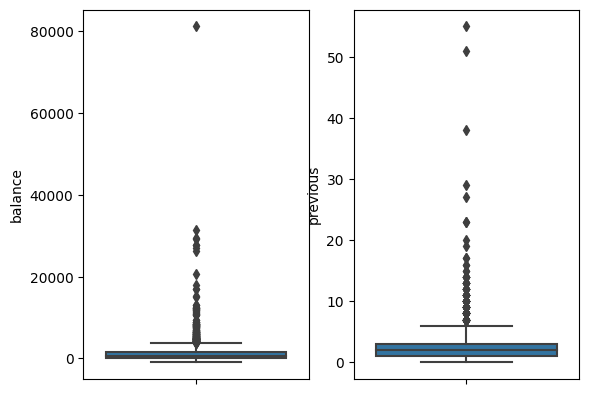

In [996]:
f, axes = plt.subplots(1, 2)
sns.boxplot(y= "balance", data=df,  orient="v", ax=axes[0])
sns.boxplot(y= "previous", data=df,   orient="v",  ax=axes[1])

In [997]:
robust_scaler = RobustScaler()
scale_cols = ['age','balance','duration','campaign','pdays','previous']
df[scale_cols] = robust_scaler.fit_transform(df[scale_cols])

In [998]:
df.describe()

age    education      balance     duration     campaign  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.207637     1.129500     0.597826     0.240431     0.909500   
std       0.705860     0.801281     2.169941     0.950890     1.378862   
min      -1.111111    -1.000000    -1.060984    -0.982833     0.000000   
25%      -0.333333     1.000000    -0.242204    -0.386266     0.000000   
50%       0.000000     1.000000     0.000000     0.000000     0.000000   
75%       0.666667     2.000000     0.757796     0.613734     1.000000   
max       3.055556     2.000000    55.892585     6.811159    10.000000   

             pdays     previous    month_sin     month_cos      day_sin  ...  \
count  2000.000000  2000.000000  2000.000000  2.000000e+03  2000.000000  ...   
mean     -0.080479     0.280750     0.225786  4.551760e-02     0.159577  ...   
std       0.751807     1.700368     0.640879  7.325957e-01     0.663511  ...   
min      -1.044223    -1.000000    -1.000000 -1.000000e+00    -0.998717  ...   
25%      -0.606277    -0.500000     0.000000 -5.000000e-01    -0.571268  ...   
50%       0.000000     0.000000     0.500000  6.123234e-17     0.299363  ...   
75%       0.393723     0.500000     0.866025  8.660254e-01     0.724793  ...   
max       3.834522    26.500000     1.000000  1.000000e+00     0.998717  ...   

       marital_married  marital_single  housing_yes     loan_yes  \
count      2000.000000     2000.000000  2000.000000  2000.000000   
mean          0.555500        0.337000     0.481500     0.125000   
std           0.497034        0.472803     0.499783     0.330802   
min           0.000000        0.000000     0.000000     0.000000   
25%           0.000000        0.000000     0.000000     0.000000   
50%           1.000000        0.000000     0.000000     0.000000   
75%           1.000000        1.000000     1.000000     0.000000   
max           1.000000        1.000000     1.000000     1.000000   

       contact_missing  contact_telephone  poutcome_no_previous_contact  \
count      2000.000000        2000.000000                   2000.000000   
mean          0.095500           0.073000                      0.227000   
std           0.293978           0.260202                      0.418997   
min           0.000000           0.000000                      0.000000   
25%           0.000000           0.000000                      0.000000   
50%           0.000000           0.000000                      0.000000   
75%           0.000000           0.000000                      0.000000   
max           1.000000           1.000000                      1.000000   

       poutcome_other  poutcome_success  subscribed_yes  
count     2000.000000       2000.000000     2000.000000  
mean         0.073500          0.222000        0.500000  
std          0.261021          0.415695        0.500125  
min          0.000000          0.000000        0.000000  
25%          0.000000          0.000000        0.000000  
50%          0.000000          0.000000        0.500000  
75%          0.000000          0.000000        1.000000  
max          1.000000          1.000000        1.000000  

[8 rows x 33 columns]

# Treat outliers

In [999]:
numericals = ['age','balance','duration','campaign','pdays','previous']

<AxesSubplot: >

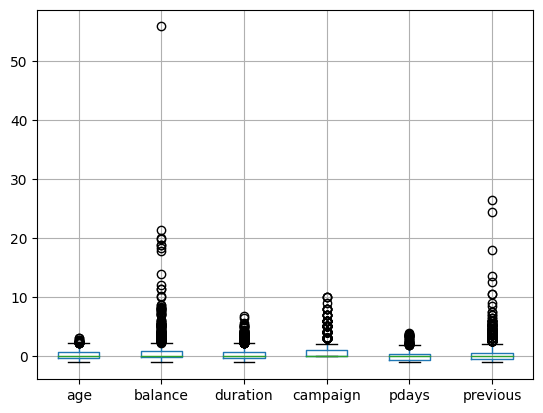

In [1000]:
df.boxplot(column=numericals)

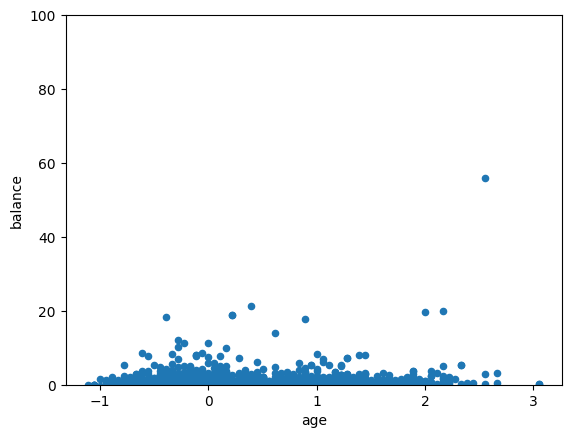

In [1001]:
#bivariate analysis age/balance
df.plot.scatter(x='age', y='balance', ylim=(0,100));

This extremely high balance is so out of the ordinary that it is not serving our predictive abilities. I believe it is better to remove it altogether than have it drag up our estimation of every other person's balance.

In [1002]:
df = df[df['balance'] < 50]

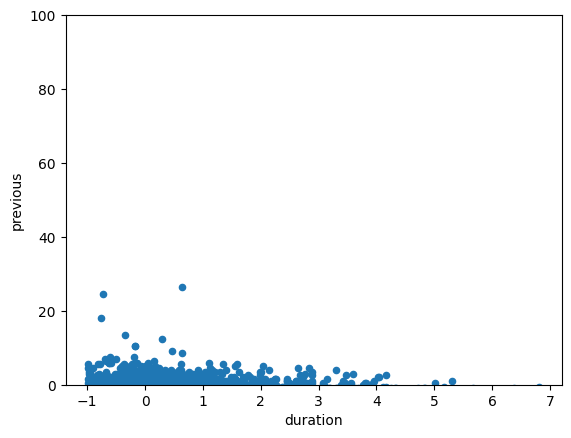

In [1003]:
#bivariate analysis duration/previous
df.plot.scatter(x='duration', y='previous', ylim=(0,100));

In [1004]:
df[df['previous'] > 20]

age  education   balance  duration  campaign     pdays  previous  \
755  -0.388889          2 -0.133749 -0.721030       2.0  0.422254      24.5   
1275 -0.055556          1 -0.082467  0.643777       2.0  3.389444      26.5   

         month_sin  month_cos   day_sin  ...  marital_married  marital_single  \
755   0.000000e+00        1.0 -0.394356  ...                0               1   
1275  1.224647e-16       -1.0  0.848644  ...                1               0   

      housing_yes  loan_yes  contact_missing  contact_telephone  \
755             1         0                0                  0   
1275            1         0                0                  0   

      poutcome_no_previous_contact  poutcome_other  poutcome_success  \
755                              0               0                 0   
1275                             0               0                 0   

      subscribed_yes  
755                0  
1275               1  

[2 rows x 33 columns]

We examine these same values in the orginal dataset just to get a better feel for the values.

In [1005]:
df_copy.sort_values('previous',ascending=False).head(2)

age         job  marital  education default  balance housing loan  \
1275  37.0  technician  married  secondary      no      432     yes   no   
755   31.0  management   single   tertiary      no      358     yes   no   

       contact  day month  duration  campaign  pdays  previous poutcome  \
1275  cellular    6   jul       386         3    776        55  failure   
755   cellular   30   jan        68         3    256        51  failure   

     subscribed  
1275        yes  
755          no

I'm not sure what would warrant the 20 extra communications (**previous**) feature given to the first two rows. In both cases, previous campaigns were failures. Perhaps the caller was a friends with these customers hehe. I'll remove them anyway because they deviate from the norm too much without any clear reason why.

In [1006]:
df = df[df['previous'] <= 20]

We will now try to normalise the data by reducing skew.

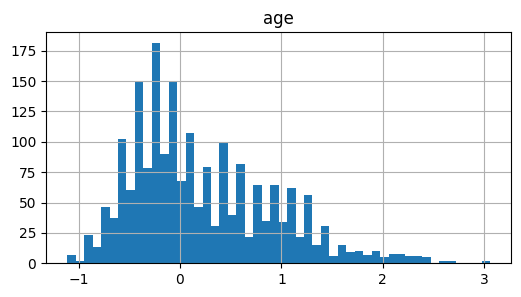

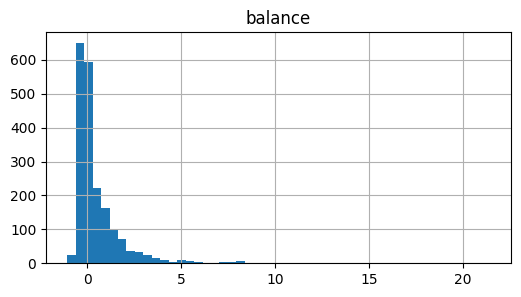

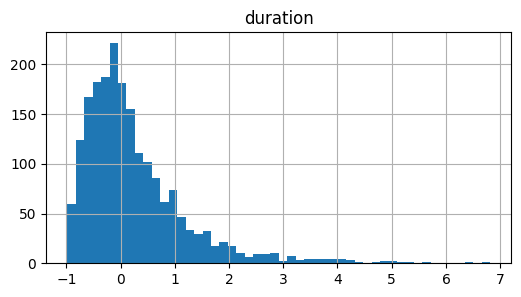

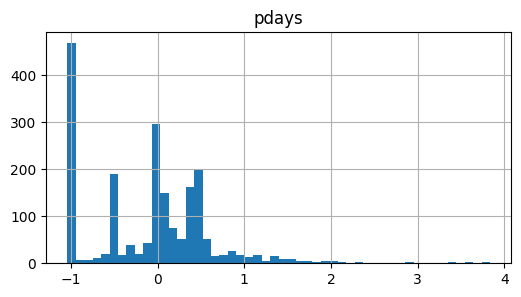

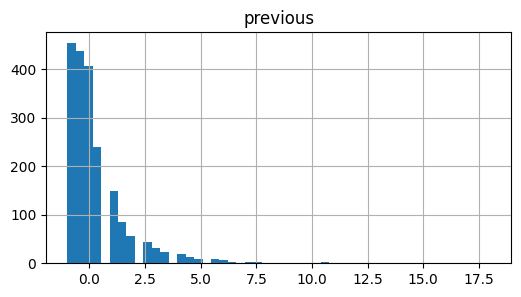

In [1007]:
for numeric in numericals:
    df.hist(numeric, bins=50, figsize=(6,3))

In [1008]:
df[numericals].min()

age        -1.111111
balance    -1.060984
duration   -0.982833
campaign    0.000000
pdays      -1.044223
previous   -1.000000
dtype: float64

In [1009]:
df['age'] = np.log(df['age']+2.12)
df['balance'] = np.log(df['balance']+2.07)
df['duration'] = np.log(df['duration']+1.99)
df['campaign'] = np.log(df['campaign']+1.01)
df['pdays'] = np.log(df['pdays']+2.05)
df['previous'] = np.log(df['previous']+2.01)

/var/folders/xh/2kbx17395jq_p4kd_p_fw5gr0000gq/T/ipykernel_11617/2130996398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = np.log(df['age']+2.12)
/var/folders/xh/2kbx17395jq_p4kd_p_fw5gr0000gq/T/ipykernel_11617/2130996398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['balance'] = np.log(df['balance']+2.07)
/var/folders/xh/2kbx17395jq_p4kd_p_fw5gr0000gq/T/ipykernel_11617/2130996398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

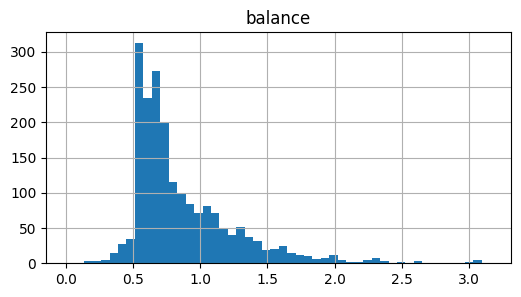

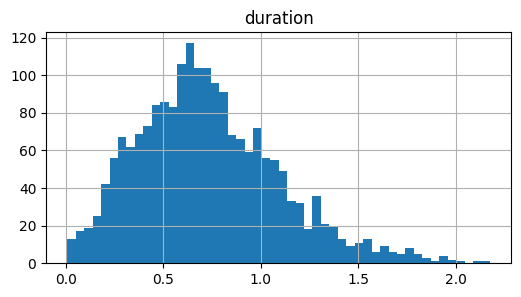

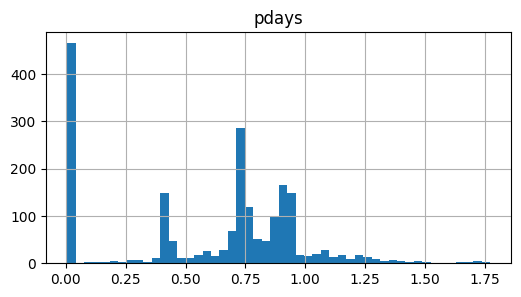

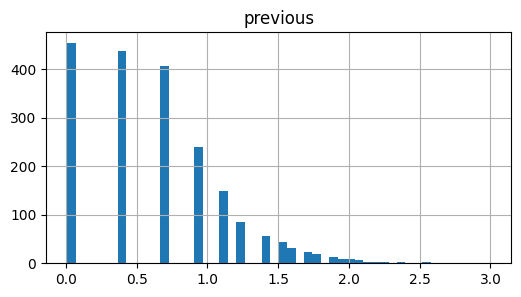

In [1010]:
for numeric in numericals:
    df.hist(numeric, bins=50, figsize=(6,3))

# Create at least one new feature from the existing ones

In [1011]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           1997 non-null   float64
 1   education                     1997 non-null   int64  
 2   balance                       1997 non-null   float64
 3   duration                      1997 non-null   float64
 4   campaign                      1997 non-null   float64
 5   pdays                         1997 non-null   float64
 6   previous                      1997 non-null   float64
 7   month_sin                     1997 non-null   float64
 8   month_cos                     1997 non-null   float64
 9   day_sin                       1997 non-null   float64
 10  day_cos                       1997 non-null   float64
 11  default_yes                   1997 non-null   uint8  
 12  job_blue-collar               1997 non-null   uint8  
 13  job

In [1012]:
df['balance'].describe()

count    1997.000000
mean        0.866993
std         0.395767
min         0.008976
25%         0.602542
50%         0.727883
75%         1.039375
max         3.156927
Name: balance, dtype: float64

Here we engineer a new feature to classify a *high risk* customer as those who:

    1. Have a balance in the lowest 20%
    2. Have previously defaulted on a loan
    3. Have an existing loan

In [1013]:
df_copy[df_copy.default == 'yes']

age            job   marital  education default  balance housing loan  \
32    34.0    blue-collar    single  secondary     yes      -60      no   no   
185   48.0    blue-collar  divorced  secondary     yes     -535     yes   no   
318   54.0        retired  divorced  secondary     yes     -200      no  yes   
450   57.0         admin.  divorced  secondary     yes     -435     yes  yes   
499   31.0     management    single  secondary     yes        0      no   no   
520   33.0    blue-collar   married  secondary     yes     -354     yes  yes   
597    NaN  self-employed   married  secondary     yes      254     yes  yes   
645   26.0     management  divorced   tertiary     yes     -402      no  yes   
674   47.0     management   married   tertiary     yes     -337      no  yes   
799   33.0    blue-collar   married    primary     yes     -744     yes   no   
864   44.0    blue-collar   married  secondary     yes     -617     yes   no   
874   52.0     management    single   tertiary     yes        0      no   no   
902   41.0     unemployed   married    primary     yes     -581     yes   no   
981   37.0     management   married   tertiary     yes        0      no   no   
1278  28.0     management    single   tertiary     yes     1414     yes   no   

       contact  day month  duration  campaign  pdays  previous poutcome  \
32    cellular    3   apr        84         1    332         1  failure   
185   cellular    2   feb       115         2    187         2  failure   
318   cellular    4   feb        71         1    243         1  failure   
450   cellular    6   feb        89         5    273         2  failure   
499   cellular   11   feb       112         4     85         2  failure   
520   cellular   28   jan       104         1    245         2  failure   
597   cellular   29   jan       194         1    188         1  failure   
645   cellular   29   jan        66         2    262         2  failure   
674   cellular   29   jan       243         4    161         2  failure   
799        NaN    8   may       206         1     -1         0      NaN   
864        NaN    8   may       172         1     -1         0      NaN   
874        NaN    8   may        98         1     -1         0      NaN   
902        NaN    8   may       218         2     -1         0      NaN   
981   cellular   17   nov        44         1    123         2  failure   
1278  cellular    8   jul       294         1    521         1  failure   

     subscribed  
32           no  
185          no  
318          no  
450          no  
499          no  
520          no  
597          no  
645          no  
674          no  
799          no  
864          no  
874          no  
902          no  
981          no  
1278        yes

In [1014]:
df['high_risk'] = (df['balance'] < df['balance'].quantile(q=0.20)) & (df['default_yes'] == 1) & (df['loan_yes'] == 1)

/var/folders/xh/2kbx17395jq_p4kd_p_fw5gr0000gq/T/ipykernel_11617/2771142695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_risk'] = (df['balance'] < df['balance'].quantile(q=0.20)) & (df['default_yes'] == 1) & (df['loan_yes'] == 1)


In [1015]:
df = pd.get_dummies(df,
                    columns=['high_risk'], 
                    drop_first=True)

We could also create a feature that is a function of both balance and age.
A customers' very large balance may seem attractive to a bank but it is somewhat offset by their age. A customer in their 40s with $1million is preferable to a customer in their 80s, since the former is likely to produce longer term gains for the bank.

In [1016]:
df[df['age'] == 0]

Empty DataFrame
Columns: [age, education, balance, duration, campaign, pdays, previous, month_sin, month_cos, day_sin, day_cos, default_yes, job_blue-collar, job_entrepreneur, job_housemaid, job_management, job_retired, job_self-employed, job_services, job_student, job_technician, job_unemployed, job_unknown, marital_married, marital_single, housing_yes, loan_yes, contact_missing, contact_telephone, poutcome_no_previous_contact, poutcome_other, poutcome_success, subscribed_yes, high_risk_True]
Index: []

[0 rows x 34 columns]

In [1017]:
df['balance_age_ratio'] = (df['balance'] / df['age'])
df['balance_age_ratio'].describe()

count    1997.000000
mean        1.313564
std         1.905756
min         0.011547
25%         0.736336
50%         1.017695
75%         1.468394
max        74.259506
Name: balance_age_ratio, dtype: float64

<AxesSubplot: ylabel='balance_age_ratio'>

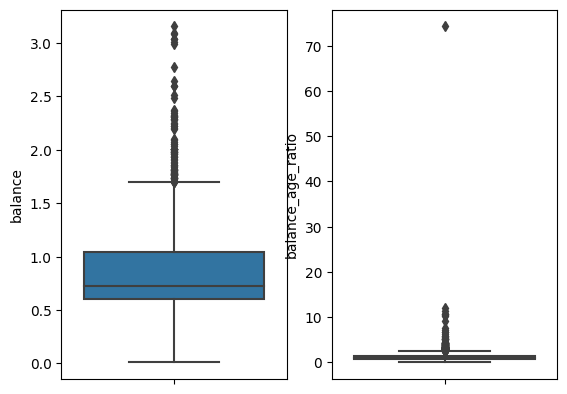

In [1018]:
f, axes = plt.subplots(1, 2)
sns.boxplot(y= "balance", data=df,  orient="v", ax=axes[0])
sns.boxplot(y= "balance_age_ratio", data=df,   orient="v",  ax=axes[1])

In [1019]:
df[df['balance_age_ratio'] > 60]

age  education   balance  duration  campaign     pdays  previous  \
1709  0.00885         -1  0.657168  1.057239  1.388791  0.005761   0.00995   

      month_sin  month_cos   day_sin  ...  housing_yes  loan_yes  \
1709   0.866025       -0.5  0.724793  ...            0         0   

      contact_missing  contact_telephone  poutcome_no_previous_contact  \
1709                0                  0                             1   

      poutcome_other  poutcome_success  subscribed_yes  high_risk_True  \
1709               0                 0               1               0   

      balance_age_ratio  
1709          74.259506  

[1 rows x 35 columns]

With our new feature, there is 1 sample that is wildly outside the norm. Since it is just one sample, simply dropping it is a reasonable approach.

In [1020]:
df = df[df['balance_age_ratio'] < 60]

<AxesSubplot: ylabel='balance_age_ratio'>

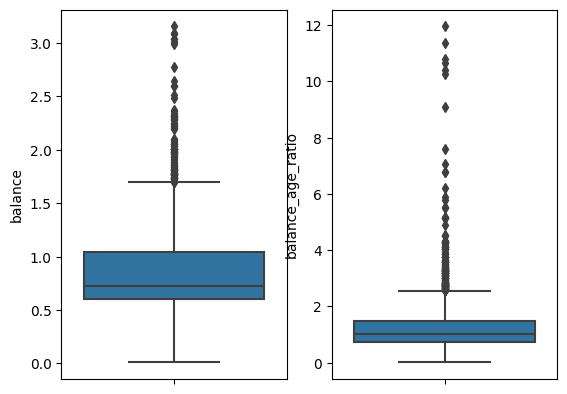

In [1021]:
f, axes = plt.subplots(1, 2)
sns.boxplot(y= "balance", data=df,  orient="v", ax=axes[0])
sns.boxplot(y= "balance_age_ratio", data=df,   orient="v",  ax=axes[1])

# SAVE TO CSV

In [1022]:
df.to_csv('bank_processed.csv')